In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from scipy.stats import multivariate_normal

In [3]:
def generateDiskData(numSamples,radii,prior):
    labels = np.where(np.random.rand(numSamples) >= prior, 1, 0)    
    data = np.empty((numSamples,2))
    labels = np.where(np.random.rand(numSamples) >= .5, 1, 0)    
    data = np.empty((numSamples,2))

    # n_gauss = np.array([multivariate_normal.rvs(0,1,numSamples), multivariate_normal.rvs(0,1,numSamples)])
    u = np.random.rand(1, numSamples) # generate N samples uniformly random in [0,1]
    angle = 2*math.pi*u
    # data = np.vstack((np.multiply(radii[0],np.cos(angle)), np.multiply(radius,np.sin(angle))))+n_gauss

    # n_gauss = multivariate_normal.rvs(0,1,numSamples)
    n_gauss = np.array([multivariate_normal.rvs(0,1,numSamples), multivariate_normal.rvs(0,1,numSamples)]).T
    for i in range(numSamples):
        if(labels[i] == 1):
            data[i,:] = np.array([radii[0]*np.cos(angle[0,i]), radii[0]*np.sin(angle[0,i])])+n_gauss[i,:]
        else:
            data[i,:] = np.array([radii[1]*np.cos(angle[0,i]), radii[1]*np.sin(angle[0,i])])+n_gauss[i,:]
    
    return data, labels


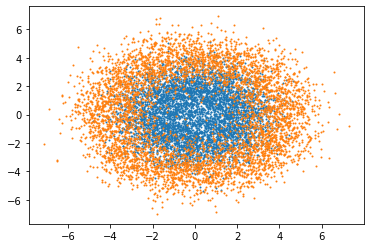

In [60]:
# Generate and Plot Data
train_data, train_labels = generateDiskData(1000,[2,4],0.5)
test_data, test_labels = generateDiskData(10000,[2,4],0.5)

plt.figure()
plt.scatter(test_data[test_labels==1,0],test_data[test_labels==1,1], s=1)
plt.scatter(test_data[test_labels==0,0],test_data[test_labels==0,1], s=1)

In [61]:
# Ignore PD Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [62]:
def cross_validation(data, k=10, verbose=False):
    '''
    Select the best box constraint hyperparameter C and the Gaussian kernel width 
    parameter σ.  Use minimum-average-cross-validation-probability-of-error to 
    select best hyperparameters.

    Parameters
    ----------
    data: pd.DataFrame
        The data to use
    k: int, optional
        Number of folds; k-fold cross validation

    Returns
    -------
    C: float
        The C hyperparameter.
    Sigma: float
        The Gaussian kernel width parameter.
    '''
    # Make k subsamples
    cv = KFold(n_splits=k)
    # Repeat the cross-validation over numerous hyparameter configurations
    C = np.arange(0.5,10.0,0.5)
    sigmas = np.arange(0.25,10.0,0.25)
    gammas = [1/sigma for sigma in sigmas] # sigma = 1/gamma
    results = pd.DataFrame()
    X = []
    for i, row in data.iterrows():
        X.append([row['x'],row['y']])
    for c in C:
        for gamma in gammas:
            model = SVC(C=c, kernel='rbf', gamma=gamma)
            scores = cross_val_score(estimator=model, X=X, y=data['Label'], cv=cv, scoring='accuracy')
            p_errs = [1-score for score in scores]
            d = {'Mean Probability of Error Score': np.mean(p_errs), 'C': c, 'Sigma': 1/gamma, 'Gamma': gamma}
            results = results.append(d, ignore_index=True)
    data = results
    results = results.sort_values(by='Mean Probability of Error Score').iloc[0]
    min_score = results['Mean Probability of Error Score']
    if(verbose):
        print('The minimum-average-cross-validation-probability-of-error is: %.3f'%min_score)
    return results['C'], results['Gamma'], data

In [63]:
def test_hyperparameters(train_data, test_data, C, gamma):
    '''
    Train a final SVM using the best combination of hyperparameters with the entire training set. 
    Classify the testing dataset samples with this trained SVM to assess performance; estimate 
    the probability error using the test set. 

    Parameters
    ----------
    train_data: pd.DataFrame
        Data to train the model
    test_data: pd.DataFrame
        Data to test the accuracy of the model
    C: float
        The C hyperparameter.
    Sigma: float
        The Gaussian kernel width parameter.

    Returns
    -------
    test_data: pd.DataFrame
        Predicted values and original testing data.
    '''
    # Train the model using the optimized hyperparameters
    X = []
    for i, row in train_data.iterrows():
        X.append([row['x'],row['y']])
    Y = train_data['Label']
    model = SVC(C=C, kernel='rbf', gamma=gamma)
    model.fit(X,Y)
    # Test the accuracy of the model
    X = []
    for i, row in test_data.iterrows():
        X.append([row['x'],row['y']])
    Y = model.predict(X)
    test_data['Predicted Label'] = Y
    return test_data

In [83]:
def cross_validation_results(data):
    '''
    Plot how the hyperparameters change the cross validation results.

    Parameters
    ----------
    Data: pd.DataFrame
        Data on the cross validation previously done.
    
    Returns
    -------
    None
    '''
    data['Accuracy'] = 1-data['Mean Probability of Error Score']
    fig, axes = plt.subplots(1,2,sharey=True,figsize=[15,10])
    sns.regplot(data=data,x='Sigma',y='Accuracy',color='skyblue',ax=axes[0],ci=0,truncate=False,order=3,line_kws={'color':'grey'})
    sns.regplot(data=data,x='C',y='Accuracy',color='maroon',ax=axes[1],ci=0,truncate=False,order=3,line_kws={'color':'grey'})
    axes[1].set_ylabel('')
    vals = axes[0].get_yticks()
    axes[0].set_yticklabels(['{:,.0%}'.format(x) for x in vals])
    # axes[0].set_xlim(0,10)
    # axes[1].set_xlim(0,10)
    # axes[0].set_ylim(.90,.95)
    # axes[1].set_ylim(.90,.95)
    axes[0].set_xticks(np.arange(0,12,2))
    axes[0].set_xticklabels(np.arange(0,12,2))
    axes[1].set_xticks(np.arange(0,12,2))
    axes[1].set_xticklabels(np.arange(0,12,2))
    axes[1].yaxis.grid(color='lightgrey', linestyle=':')
    axes[1].xaxis.grid(color='lightgrey', linestyle=':')
    axes[1].set_axisbelow(True)
    axes[0].yaxis.grid(color='lightgrey', linestyle=':')
    axes[0].xaxis.grid(color='lightgrey', linestyle=':')
    axes[0].set_axisbelow(True)
    fig.subplots_adjust(left=0.12, right=0.965, top=.94, bottom=0.22, wspace=0.10, hspace=0.18)
    plt.show()
    # plt.savefig('./q2_cross_validation.pdf')
    # plt.clf()
    # plt.close()
    return None


In [84]:
def plot_model_results(data):
    '''
    Plot the accuracy of determined hyperparameters in training the model.

    Parameters
    ----------
    Data: pd.DataFrame
        Data on the model fit previously done.
    
    Returns
    -------
    None
    '''
    fig, ax = plt.subplots(1, 1, figsize=[5,4.6])
    correct = 0
    for idx,row in data.iterrows():
        true_label = row['Label']
        decision   = row['Predicted Label']
        x = row['x']
        y = row['y']
        if(true_label==1.0):
            if(true_label==decision):
                ax.plot(x,y,'go', alpha=0.1)
                correct = correct + 1
            else:
                ax.plot(x,y,'ro', alpha=0.1)
        else:
            if(true_label==decision):
                ax.plot(x,y,'g^', alpha=0.1)
                correct = correct + 1
            else:
                ax.plot(x,y,'r^', alpha=0.1)
    print('Model accuracy was %.3f'%(correct/data.shape[0]))
    # ax.set_ylim(-30,30)
    # ax.set_xlim(-30,30)
    ax.yaxis.grid(color='lightgrey', linestyle=':')
    ax.xaxis.grid(color='lightgrey', linestyle=':')
    ax.set_axisbelow(True)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='1', markerfacecolor='grey', markersize=15),
                        Line2D([0], [0], marker='^', color='w', label='0', markerfacecolor='grey', markersize=15)]
    legend0 = ax.legend(handles=legend_elements, title='True Class Label', loc='upper right')
    legend_elements = [Patch(facecolor='g', edgecolor='g', label='True'),
                        Patch(facecolor='r', edgecolor='r', label='False')]
    legend1 = ax.legend(handles=legend_elements, title='Correctly Classified', loc='lower right')
    ax.add_artist(legend0)
    fig.subplots_adjust(left=0.12, right=0.965, top=.96, bottom=0.10)
    plt.show()
    # plt.savefig('./q2_model_results.pdf')
    # plt.clf()
    # plt.close()
    return None


The minimum-average-cross-validation-probability-of-error is: 0.171
C: 0.500
Sigma: 9.500


C:\Users\meuli\AppData\Local\Temp\ipykernel_33060\3542527005.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels(['{:,.0%}'.format(x) for x in vals])


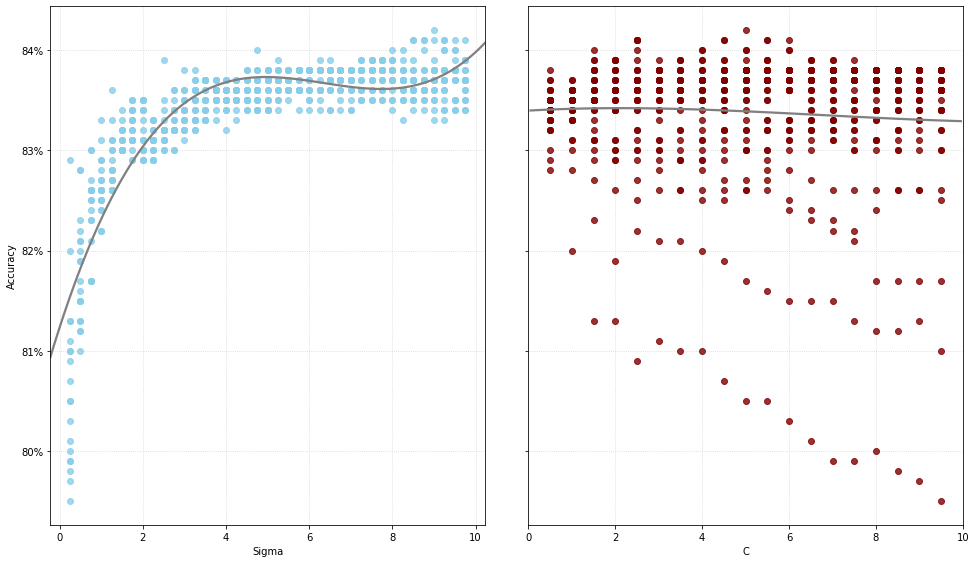

Model accuracy was 0.835


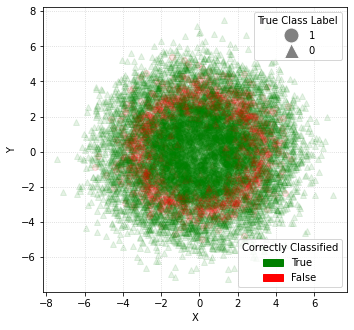

In [85]:
radii = [2,4]
prior = 0.5
train_data, train_labels = generateDiskData(1000,radii,prior)
test_data, test_labels = generateDiskData(10000,radii,prior)

# Generate data and convert to pandas.DataFrame
n_labels = 2
N = 1000
# data, labels = generateMultiringDataset(n_labels, N)
train = pd.DataFrame({'x': train_data[:,0], 'y': train_data[:,1], 'Label': train_labels})
N = 10000
# data, labels = generateMultiringDataset(n_labels, N)
test = pd.DataFrame({'x': test_data[:,0], 'y': test_data[:,1], 'Label': test_labels})
# Run functions

C, gamma, data = cross_validation(train, verbose=True)
# data.to_csv('./q2_cross_validation_results.csv')
print('C: %.3f'%C)
print('Sigma: %.3f'%(1/gamma))
results = test_hyperparameters(train, test, C, gamma)
results.to_csv('./q2_model_results.csv')

# Plot cross validation results

data = pd.read_csv('./q2_cross_validation_results.csv', index_col=0)
cross_validation_results(data)

# Plot model results
data = pd.read_csv('./q2_model_results.csv', index_col=0)
plot_model_results(data)

In [4]:
class TwoLayerMLP(nn.Module):
    # The nn.CrossEntropyLoss() loss function automatically performs a log_softmax() to 
    # the output when validating, on top of calculating the negative-log-likelihood using 
    # nn.NLLLoss(), while also being more stable numerically... So don't implement from scratch
    # https://pytorch.org/docs/stable/generated/torch.nn.Module.html
    
    def __init__(self, d_in, d_hidden, C):
        super(TwoLayerMLP, self).__init__()
        
        self.fc1 = nn.Linear(d_in, d_hidden)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(d_hidden, C)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)  # fc to perceptrons
        x = self.relu(x) # or self.softplus(x) for smooth-ReLU, empirically worse than ReLU
        x = self.fc2(x)  # connect to output layer
        x = self.log_softmax(x)  # for outputs that sum to 1
        return x

In [5]:
def train_model(model, data, labels, criterion, optimizer, num_epochs=25):
    # Set up training data
    X_train = torch.FloatTensor(data)
    y_train = torch.LongTensor(labels)

    # Optimize the neural network
    for epoch in range(num_epochs):
        # Set grads to zero explicitly before backprop
        optimizer.zero_grad()
        outputs = model(X_train)
        # Criterion computes the cross entropy loss between input and target
        loss = criterion(outputs, y_train)
        # Backward pass to compute the gradients through the network
        loss.backward()
        # GD step update
        optimizer.step()

    return model

In [6]:
def model_predict(model, data):
    # Set up test data as tensor
    X_test = torch.FloatTensor(data)

    # Evaluate nn on test data and compare to true labels
    predicted_labels = model(X_test)
    # Back to numpy
    predicted_labels = predicted_labels.detach().numpy()
    
    return np.argmax(predicted_labels, 1)

In [7]:
def mse(y_preds, y_true):
    # Residual error (X * theta) - y
    error = y_preds - y_true
    # Loss function is MSE
    return np.mean(error ** 2)

In [34]:
def model_order_selection(X_train, y_train, folds, poly_deg):

  C = len(np.unique(y_train))

  cv = KFold(n_splits=folds, shuffle=True)

  # Polynomial degrees ("hyperparameters") to evaluate 
  degs = np.arange(1, poly_deg, 1)
  n_degs = np.max(degs)

  # scores = cross_val_score(estimator=trained_model, X=X_train, y=y_train, cv=cv, scoring='accuracy')
#   mse_valid_mk = np.empty((n_degs, folds)) 
#   mse_train_mk = np.empty((n_degs, folds)) # Indexed by model m, data partition k
  error_prob=np.empty((n_degs,folds))
  all_models = []

  # 
  for deg in degs:
    k = 0

    # split training set for 10-fold cross validation
    # for each of the 10 smaller sets, train model for 1-10 perceptrons
    for fold, (train_indices, valid_indices) in enumerate(cv.split(X_train)):
        # Extract the training and validation sets from the K-fold split
        X_train_k = X_train[train_indices]
        y_train_k = y_train[train_indices]
        X_valid_k = X_train[valid_indices]
        y_valid_k = y_train[valid_indices]

        model = TwoLayerMLP(X_train.shape[1], deg, C)      
        
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        # The nn.CrossEntropyLoss() loss function automatically performs a log_softmax() to 
        # the output when validating, on top of calculating the negative-log-likelihood using 
        # nn.NLLLoss(), while also being more stable numerically... So don't implement from scratch
        criterion = nn.CrossEntropyLoss()
        trained_model = train_model(model, X_train_k, y_train_k, criterion, optimizer, num_epochs=200)
        all_models.append(trained_model)

        # Make predictions from validation data
        # y_train_pred = model_predict(trained_model,X_train_k)
        y_valid_pred = model_predict(trained_model,X_valid_k)

        num_errors = len(np.argwhere(y_valid_pred != y_valid_k))
        error_prob[deg-1,k] = num_errors/len(y_valid_k)

        # Record MSE as well for this model and k-fold
        # mse_train_mk[deg - 1, k] = mse(y_train_pred, y_train_k)
        # mse_valid_mk[deg - 1, k] = mse(y_valid_pred, y_valid_k)
        k += 1

        # # Saving the model
        # save_path = f'./model-fold-{fold}.pth'
        # torch.save(model.state_dict(), save_path)
    # print("hit rate: ", truelist)
    #print("Num Perceptrons = ",deg, " Hit Rate: ", np.mean(truelist[]))

  error_prob_m = np.mean(error_prob, axis=1)

#   # STEP 3: Compute the average MSE loss for that model (based in this case on degree d)
#   mse_train_m = np.mean(mse_train_mk, axis=1) # Model average CV loss over folds
#   mse_valid_m = np.mean(mse_valid_mk, axis=1) 


  # +1 as the index starts from 0 while the degrees start from 1
  optimal_d = np.argmin(error_prob_m) + 1

  optimal_model = all_models[optimal_d-1]
  #print("The model selected to best fit the data without overfitting is: d={}".format(optimal_d))
  optimal_hit = error_prob_m[optimal_d-1]
  print("Perceptrons: ", optimal_d, "  Probability of Error: ",optimal_hit)

  return optimal_d, error_prob_m

Perceptrons:  19   Probability of Error:  0.15
Misclassification Probability =  [0.1702]


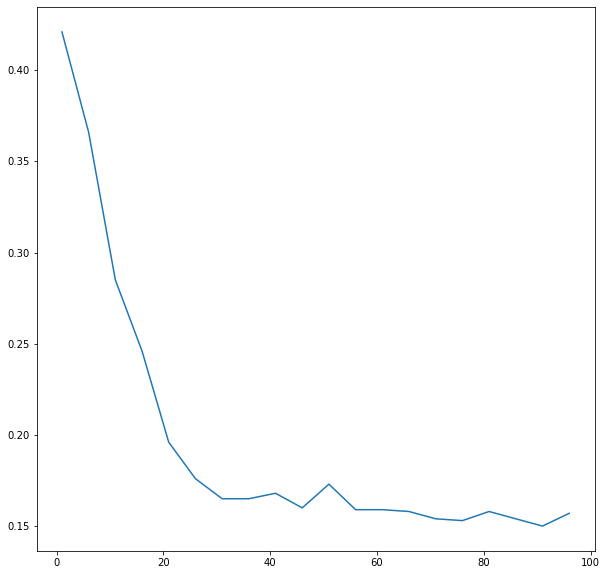

In [36]:
import torch
import torch.nn as nn

fig_all, ax_all = plt.subplots(figsize=(10, 10))
# fig_1, ax_1 = plt.subplots(figsize=(10, 10))
# Generate and Plot Data
samples = 1000
X_train, y_train = generateDiskData(samples,[2,4],0.5)
X_test, y_test = generateDiskData(10000,[2,4],0.5)

C = 2
degs = np.arange(1, 100, 5)
err_prob_est = []

op_d, err_prob_m = model_order_selection(X_train, y_train, folds=10, poly_deg=len(degs)+1)
ax_all.plot(degs,err_prob_m,label=samples)

model = TwoLayerMLP(X_train.shape[1], op_d, C)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
trained_model = train_model(model, X_train, y_train, criterion, optimizer, num_epochs=200)
y_test_pred = model_predict(trained_model,X_test)


num_errors = len(np.argwhere(y_test_pred != y_test))
err_prob_est.append(num_errors/len(y_test))
print("Misclassification Probability = ",err_prob_est)
# ax_1.scatter(samples,err_prob_est)
# mse_test = mse(y_test_pred, y_test)
# print(mse_test, " = MSE")

# truehit = len(np.argwhere(y_train_pred == y_train))
# print(truehit/len(y_train))

Approximated Minimum Error =  0.17014345077408577


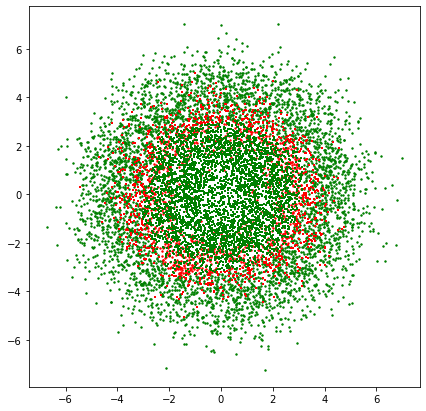

In [37]:
decisions = y_test_pred
labels = y_test
x = X_test
w = trained_model
priors = [0.5,0.5]

Nlabels = np.array((sum(labels == 0), sum(labels == 1)))
# True Negative Probability
ind_00 = np.argwhere((decisions==0) & (labels==0))
p_00 = len(ind_00) / Nlabels[0]
# False Positive Probability
ind_10 = np.argwhere((decisions==1) & (labels==0))
p_10 = len(ind_10) / Nlabels[0]
# False Negative Probability
ind_01 = np.argwhere((decisions==0) & (labels==1))
p_01 = len(ind_01) / Nlabels[1]
# True Positive Probability
ind_11 = np.argwhere((decisions==1) & (labels==1))
p_11 = len(ind_11) / Nlabels[1]

# Probability of error for MAP classifier, empirically estimated
prob_error_approx = (p_10 *priors[0] + (1 - p_11)* priors[1])
print("Approximated Minimum Error = ", prob_error_approx)


fig_disc_grid, ax_disc = plt.subplots(figsize=(7, 7));
ax_disc.scatter(x[ind_00, 0], x[ind_00, 1], c='g',marker='o', label="Correct Class 0", s=2)
ax_disc.scatter(x[ind_10, 0], x[ind_10, 1],c='r',marker='o', label="Incorrect Class 0", s=2)
ax_disc.scatter(x[ind_01, 0], x[ind_01, 1], c='r',marker='+', label="Incorrect Class 1", s=2)
ax_disc.scatter(x[ind_11, 0], x[ind_11, 1], c='g',marker='+', label="Correct Class 1", s=2)


In [26]:
# Vis Test
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch

def plot_decision_boundary(dataset, labels, model, steps=1000, color_map='Paired'):
    color_map = plt.get_cmap(color_map)
    # Define region of interest by data limits
    xmin, xmax = dataset[:, 0].min() - 1, dataset[:, 0].max() + 1
    ymin, ymax = dataset[:, 1].min() - 1, dataset[:, 1].max() + 1
    steps = 1000
    x_span = np.linspace(xmin, xmax, steps)
    y_span = np.linspace(ymin, ymax, steps)
    xx, yy = np.meshgrid(x_span, y_span)

    # Make predictions across region of interest
    model.eval()
    labels_predicted = model(Variable(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()))

    # Plot decision boundary in region of interest
    labels_predicted = [0 if value <= 0.5 else 1 for value in labels_predicted.detach().numpy()]
    z = np.array(labels_predicted).reshape(xx.shape)
    
    fig, ax = plt.subplots()
    ax.contourf(xx, yy, z, cmap=color_map, alpha=0.5)

    # Get predicted labels on training data and plot
    train_labels_predicted = model(dataset)
    ax.scatter(dataset[:, 0], dataset[:, 1], c=labels.reshape(labels.size()[0]), cmap=color_map, lw=0)
    plt.show()
    return fig, ax

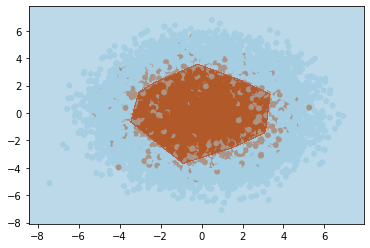

In [32]:
# VIS Test
# plot_decision_boundary(X_test,y_test,trained_model)

dataset = X_test
labels = y_test
model = trained_model
steps=1000
color_map='Paired'

color_map = plt.get_cmap(color_map)
# Define region of interest by data limits
xmin, xmax = dataset[:, 0].min() - 1, dataset[:, 0].max() + 1
ymin, ymax = dataset[:, 1].min() - 1, dataset[:, 1].max() + 1
steps = 1000
x_span = np.linspace(xmin, xmax, steps)
y_span = np.linspace(ymin, ymax, steps)
xx, yy = np.meshgrid(x_span, y_span)

# Make predictions across region of interest
labels_predicted = model_predict(trained_model,torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float())
# model.eval()
# labels_predicted = model(Variable(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()))

# Plot decision boundary in region of interest
# labels_predicted = [0 if value <= 0.5 else 1 for value in labels_predicted.detach().numpy()]
z = np.array(labels_predicted).reshape(xx.shape)

fig, ax = plt.subplots()
ax.contourf(xx, yy, z, cmap=color_map, alpha=0.5)

# Get predicted labels on training data and plot
# train_labels_predicted = model(dataset)
ax.scatter(dataset[:, 0], dataset[:, 1], c=labels.reshape(labels.shape[0]), cmap=color_map, lw=0)
ax.contourf(xx, yy, z, cmap=color_map, alpha=0.5)
plt.show()
# return fig, ax